In [ ]:
import numpy as np
import cv2
import pandas as pd
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, CuDNNLSTM, Flatten, TimeDistributed
from keras.models import Model
from keras import backend as K
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [ ]:
videoList = []
def saveFrames(listOfVideos):
    csvList = pd.read_csv('/content/sample_data/output.csv')
    funcVids = list(i for i in csvList.iloc[:,1])
    #fps = getFps
    counter = 0
    for videos in funcVids:
      video = cv2.VideoCapture(videos)
      fps = int(video.get(cv2.CAP_PROP_FPS))
      while True:
        success, image = video.read()
        if not success:
          break
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        gray = cv2.resize(gray,(320,180))
              #resize 180 320
        listOfVideos.append(gray)
        if counter == 74:
          counter = 0
          break
        counter +=1
    listOfVideos = np.array(listOfVideos).reshape(-1, 75, gray.shape[0], gray.shape[1], 1)
    return listOfVideos, fps

videoList, fps = saveFrames(videoList)

In [ ]:
getCsv = pd.read_csv('/content/sample_data/output.csv')
y = getCsv.iloc[:,2]
x_train, x_test, y_train, y_test = train_test_split(videoList, y)
x_train.shape
x_test.shape

(35, 75, 180, 320, 1)

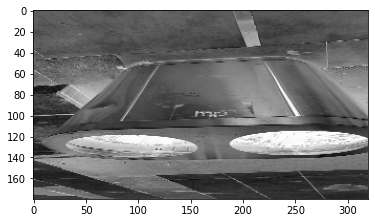

In [ ]:
x_train = x_train.reshape(-1,180,320)/75
plt.imshow(x_train[5], cmap = plt.cm.binary)
plt.show()

In [ ]:
input_img = Input(shape=(75, 180, 320, 1))

x = TimeDistributed(Conv2D(32, (3, 3), activation='relu', padding='same'))(input_img)
x = TimeDistributed(MaxPooling2D((2, 2), padding='same'))(x)
x = TimeDistributed(Conv2D(16, (3, 3), activation='relu', padding='same'))(x)
x = TimeDistributed(MaxPooling2D((2, 2), padding='same'))(x)
x = TimeDistributed(Conv2D(8, (3, 3), activation='relu', padding='same'))(x)
x = TimeDistributed(MaxPooling2D((2, 2), padding='same'))(x)
x = TimeDistributed(Flatten())(x)
x = CuDNNLSTM(15)(x)
x = tf.keras.layers.Dropout(.3)(x)
x = Dense(1, activation="sigmoid")(x)


model = Model(input_img,x)
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()


history = model.fit(x_train, y_train,epochs=50,batch_size=1,shuffle=True,validation_data=(x_test, y_test))

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 75, 180, 320, 1)  0         
                             ]                                   
                                                                 
 time_distributed_28 (TimeDi  (None, 75, 180, 320, 32)  320      
 stributed)                                                      
                                                                 
 time_distributed_29 (TimeDi  (None, 75, 90, 160, 32)  0         
 stributed)                                                      
                                                                 
 time_distributed_30 (TimeDi  (None, 75, 90, 160, 16)  4624      
 stributed)                                                      
                                                                 
 time_distributed_31 (TimeDi  (None, 75, 45, 80, 16)   0   

ValueError: ignored

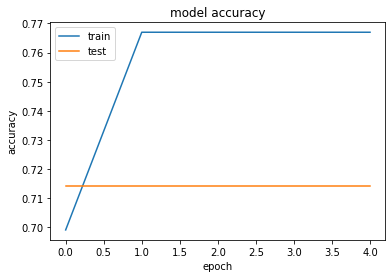

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()